<a href="https://colab.research.google.com/github/jordenpiu/Automated-traffic-Lightining-System/blob/master/CIFAR10_fs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/sicara/easy-few-shot-learning.git

  Cloning https://github.com/sicara/easy-few-shot-learning.git to /tmp/pip-req-build-rd3yh_a4
  Running command git clone -q https://github.com/sicara/easy-few-shot-learning.git /tmp/pip-req-build-rd3yh_a4
     |████████████████████████████████| 61kB 5.7MB/s 
  Created wheel for easyfsl: filename=easyfsl-0.1.0-cp37-none-any.whl size=14341 sha256=02e5340d80f171786a78f10cf60649b3a8dbfbc926a96981c0482d62bcea873b
  Stored in directory: /tmp/pip-ephem-wheel-cache-5v54g7u5/wheels/42/ae/30/b53c08a03abb854f201af0092283b06a0cd6bb68adea34e4b5
Successfully built easyfsl


In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.data_tools import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [4]:
image_size = 32

# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it

train_set = CIFAR10(
    root="./data",
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = CIFAR10(
    root="./data",
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
test_set

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=[36, 36], interpolation=bilinear)
               CenterCrop(size=(32, 32))
               ToTensor()
           )

In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
N_WAY = 10 # Number of classes in a task
N_SHOT = 20 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "labels" field. Check the code if you have any doubt!
test_set.labels = [instance[1] for instance in test_set]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


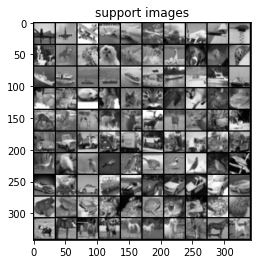

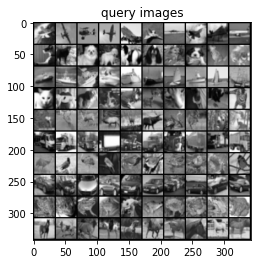

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)


In [ ]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set[example_class_ids[example_query_labels[i]]]} / {test_set[example_class_ids[example_predicted_labels[i]]]}"
    )


Ground Truth / Predicted
(tensor([[[0.0784, 0.1569, 0.2471,  ..., 0.4157, 0.3843, 0.3569],
         [0.1608, 0.2353, 0.2863,  ..., 0.4000, 0.3765, 0.3608],
         [0.2235, 0.2980, 0.3216,  ..., 0.3529, 0.3255, 0.3020],
         ...,
         [0.5412, 0.5059, 0.4588,  ..., 0.5216, 0.6392, 0.5255],
         [0.5882, 0.5686, 0.5333,  ..., 0.4039, 0.5490, 0.4392],
         [0.5961, 0.5961, 0.5882,  ..., 0.2588, 0.4706, 0.4431]],

        [[0.0784, 0.1569, 0.2471,  ..., 0.4157, 0.3843, 0.3569],
         [0.1608, 0.2353, 0.2863,  ..., 0.4000, 0.3765, 0.3608],
         [0.2235, 0.2980, 0.3216,  ..., 0.3529, 0.3255, 0.3020],
         ...,
         [0.5412, 0.5059, 0.4588,  ..., 0.5216, 0.6392, 0.5255],
         [0.5882, 0.5686, 0.5333,  ..., 0.4039, 0.5490, 0.4392],
         [0.5961, 0.5961, 0.5882,  ..., 0.2588, 0.4706, 0.4431]],

        [[0.0784, 0.1569, 0.2471,  ..., 0.4157, 0.3843, 0.3569],
         [0.1608, 0.2353, 0.2863,  ..., 0.4000, 0.3765, 0.3608],
         [0.2235, 0.2980, 0.3216

In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 100/100 [00:08<00:00, 12.40it/s]

Model tested on 100 tasks. Accuracy: 31.62%
